In [10]:
# resetting the entire session
%reset -f  
# Iris data-set
from sklearn.datasets import load_iris

# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
X = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((120, 4), (120,))

### Quantum Machine Learning Model
we’ll train a variational quantum classifier (VQC), available in Qiskit Machine Learning 
 Two of its central elements are the feature map and ansatz.

In [12]:
# features circuit
from qiskit.circuit.library import ZZFeatureMap
num_features = X.shape[1]
feature_circ = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_circ.decompose().draw(output='text', fold=-1)

┌───┐┌─────────────┐                                                                                                                                                                                                                            
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■────────────────────────────────────■─────────■─────────────────────────────────────────■──────────────────────────────────────────────────────────────────────────────────────
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │                                    │         │                                         │                                                                                      
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼────────────────────────────────────┼────■────┼────────────────────────────────────■────┼────■────────────────────────────────────■────────────────────────────────────────────
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐  │  ┌──────────────────────────────┐┌─┴─┐  │    │                                    │                                            
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[2])) ├┤ X ├┤ X ├──┼──┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──┼────┼────────────────────────────────────┼────■────────────────────────────────────■──
     ├───┤├─────────────┤                                          └───┘└──────────────────────────────┘└───┘└───┘┌─┴─┐├──────────────────────────────┤└───┘┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_3: ┤ H ├┤ P(2.0*x[3]) ├─────────────────────────────────────────────────────────────────────────────────────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[3])) ├─────┤ X ├┤ X ├┤ P(2.0*(π - x[1])*(π - x[3])) ├┤ X ├┤ X ├┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├
     └───┘└─────────────┘                                                                                         └───┘└──────────────────────────────┘     └───┘└───┘└──────────────────────────────┘└───┘└───┘└──────────────────────────────┘└───┘

In [13]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import ParameterVector

def rotation_block(circuit, parameters):
    # assumes nb of params equal to num of qubits
    for i in range(circuit.num_qubits):
        circuit.ry(parameters[i],i)

def non_linear(circuit, param, qubit):
    # the circuit, the parameter and the qubit of interest
    circuit.ry(param, qubit)
    circuit.measure(qubit, 0)
    circuit.ry(-param, qubit)

def myAnsatz(nFeat, reps, nonlin_qubits, barrier=True, final_rotation=True):
    # nFeat number of qubits here
    # nonlin_qubits list of qubits where we want to have non linearity
    nb = len(nonlin_qubits)
    n=nFeat+nb
    # nFeat+nb parameters for each step of the reps, plus nFeat depending on whether we want a final rotation layer or not
    if final_rotation:
        params=(n)*reps+nFeat
    else:
        params=(n)*reps
    beta = ParameterVector('beta', length=params)
    qubits = QuantumRegister(nFeat,'q')
    
    meas = ClassicalRegister(nFeat,'meas')
    test = QuantumCircuit(qubits, meas)

    #we'll look at the parameters mod n, the first nFeat
    for p in range(reps):
        #rotation block, looking at the nFeat parameters first
        rotation_block(test, beta[n*p:n*p+nFeat])
        if barrier: test.barrier()
        
        #entanglement block, here linear but can easily be changed depending on what you want to test by changing the cx connexions
        test.cx(range(nFeat-2,-1,-1), range(nFeat-1,0,-1))
        if barrier: test.barrier()
    
        # non-linear part, we'll check the last nb of parameters mod n 
        for k,qubit in enumerate(nonlin_qubits):
            par=n*p+nFeat+k
            non_linear(test, beta[par],qubit)
        if barrier: test.barrier()
        
    #final rotation block, optional
    if final_rotation: 
        rotation_block(test,beta[params-nFeat:params])
        if barrier: test.barrier()
    test.measure(range(nFeat),meas)
    return test, qubits, meas
# Function to extract parameter names from a circuit

In [14]:
# Anzatz circuit
nReps=3
nonLinQL=[]  # standard anztatz
#nonLinQL=[0]  # add mid-circuit measurement nonline anztatz
ansatz_circ = myAnsatz(num_features, reps=nReps, nonlin_qubits=nonLinQL, barrier=True, final_rotation=True)[0]
ansatz_circ.decompose().draw(output='text', fold=-1)

┌────────────────┐ ░                 ░  ░ ┌────────────────┐ ░                 ░  ░  ┌────────────────┐ ░                 ░  ░ ┌─────────────────┐ ░ ┌─┐         
   q_0: ┤ R(beta[0],π/2) ├─░─────────────■───░──░─┤ R(beta[4],π/2) ├─░─────────────■───░──░──┤ R(beta[8],π/2) ├─░─────────────■───░──░─┤ R(beta[12],π/2) ├─░─┤M├─────────
        ├────────────────┤ ░           ┌─┴─┐ ░  ░ ├────────────────┤ ░           ┌─┴─┐ ░  ░  ├────────────────┤ ░           ┌─┴─┐ ░  ░ ├─────────────────┤ ░ └╥┘┌─┐      
   q_1: ┤ R(beta[1],π/2) ├─░────────■──┤ X ├─░──░─┤ R(beta[5],π/2) ├─░────────■──┤ X ├─░──░──┤ R(beta[9],π/2) ├─░────────■──┤ X ├─░──░─┤ R(beta[13],π/2) ├─░──╫─┤M├──────
        ├────────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ├────────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ┌┴────────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ├─────────────────┤ ░  ║ └╥┘┌─┐   
   q_2: ┤ R(beta[2],π/2) ├─░───■──┤ X ├──────░──░─┤ R(beta[6],π/2) ├─░───■──┤ X ├──────░──░─┤ R(beta[10],π/2) ├─░───■──┤ X ├──────░──░─┤ R(beta[14],π/2) ├─░──╫──╫─┤M├───
        ├────────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├────────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├─────────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├─────────────────┤ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ R(beta[3],π/2) ├─░─┤ X ├───────────░──░─┤ R(beta[7],π/2) ├─░─┤ X ├───────────░──░─┤ R(beta[11],π/2) ├─░─┤ X ├───────────░──░─┤ R(beta[15],π/2) ├─░──╫──╫──╫─┤M├
        └────────────────┘ ░ └───┘           ░  ░ └────────────────┘ ░ └───┘           ░  ░ └─────────────────┘ ░ └───┘           ░  ░ └─────────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                              0  1  2  3

In [15]:
# tools for minimizer
# To make the training process faster, we choose a gradient-free optimizer.
from qiskit.algorithms.optimizers import COBYLA
nIter=100
optimizer = COBYLA(maxiter=nIter)

In [16]:
from matplotlib import pyplot as plt
from IPython.display import clear_output
import time

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
plt.tstart=time.time()

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    nEp=len(objective_func_vals)
    elaT = time.time() - plt.tstart
    txt='epoch:%d  elaT=%.0f (sec)'%(nEp,elaT)
    if nEp<10 or nEp%10==0: print()
    plt.title("Objective function, "+txt)
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.grid(color='b', linestyle='--', linewidth=0.5)
    plt.show()

### Training of VQC= variational quantum classifier 

In [17]:
if 1:  # backend = density matrix simulator
    from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Options, Session
    #load the service
    service = QiskitRuntimeService(channel = 'ibm_quantum')
    backend = service.get_backend('ibmq_qasm_simulator') # change this for a real execution
    # create the program for samplig results on a backend
    options = Options()
    options.resilience_level = 0  # no need to post-process for ideal backend
    options.execution.shots =10000
    session = Session(backend=backend)
    sampler = Sampler(session=session, options=options)
else:  # backend= state vector 
    assert len(nonLinQL)==0  # it can't handle mid-circui measurements
    from qiskit.primitives import Sampler  # state vector
    sampler = Sampler()


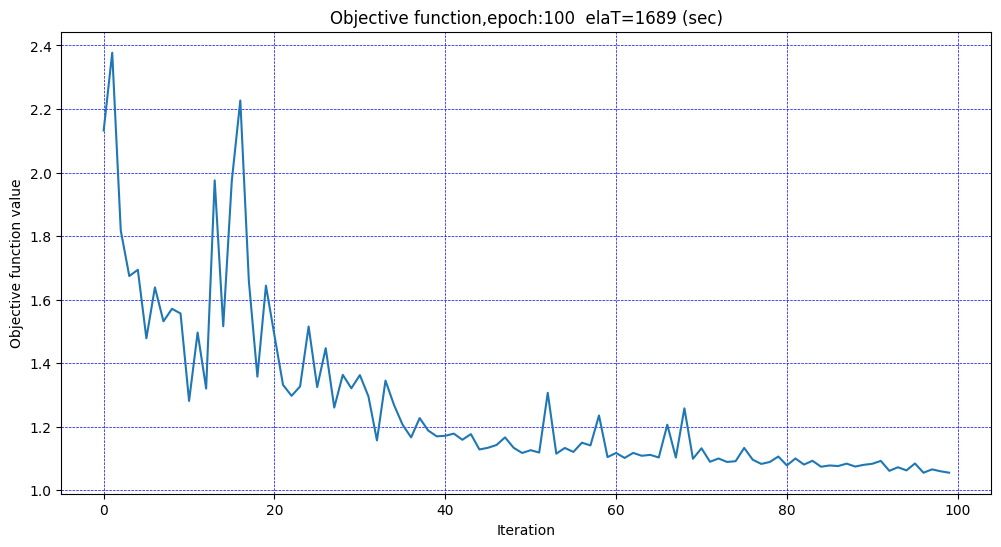

Training time: 1683 seconds, last value:1.06


In [18]:
# Training may take some time. Please, be patient.
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_circ,
    ansatz=ansatz_circ,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
# Fit the VQC on the training data
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds, last value:%.2f"%objective_func_vals[-1])

### predict for few samples

In [19]:
# Predict labels for the test data
y_pred = vqc.predict(X_test)

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)

print(conf_matrix)

[[10  0  0]
 [ 0  1  8]
 [ 0  0 11]]


In [20]:
# Now we check out how well our classical model performs. 
# mean accuracy of the classifier
train_score_c4 = vqc.score(X_train, y_train)
test_score_c4 = vqc.score(X_test, y_test)

print(f"mean accuracy  on the training dataset: {train_score_c4:.2f}")
print(f"mean accuracy on the test dataset:     {test_score_c4:.2f}")

mean accuracy  on the training dataset: 0.72
mean accuracy on the test dataset:     0.73


In [21]:
# run full circuit for 
weights=vqc.weights
weights.shape, weights

((16,),
 array([ 0.93469493,  1.66080902,  1.47895534,  0.58314058,  1.80314885,
         0.53462677, -0.10813731,  0.76938491,  0.34004182,  1.77997628,
         0.60039666,  0.2379953 ,  1.06795877,  0.78790792,  0.25830392,
         0.02329138]))

In [22]:
nSamp=20
samples=X_test[:nSamp]
labels=y_test[:nSamp]
pred=vqc.predict(samples)
nok=0
for p,t in zip(pred,labels):
    print(p,t,p==t)
    nok+=p==t
print('avr prob=%.2f'%(nok/nSamp))

2 1 False
0 0 True
2 2 True
2 1 False
2 1 False
0 0 True
2 1 False
2 2 True
2 1 False
2 1 False
2 2 True
0 0 True
0 0 True
0 0 True
0 0 True
2 1 False
2 2 True
1 1 True
2 1 False
2 2 True
avr prob=0.60


In [23]:
vqc.circuit.draw(output='text', fold=130)

┌────────────────────────────────────┐┌─────────────┐ ░                 ░  ░ ┌─────────────┐ ░                 ░  ░ »
   q_0: ┤0                                   ├┤ Ry(beta[0]) ├─░─────────────■───░──░─┤ Ry(beta[4]) ├─░─────────────■───░──░─»
        │                                    │├─────────────┤ ░           ┌─┴─┐ ░  ░ ├─────────────┤ ░           ┌─┴─┐ ░  ░ »
   q_1: ┤1                                   ├┤ Ry(beta[1]) ├─░────────■──┤ X ├─░──░─┤ Ry(beta[5]) ├─░────────■──┤ X ├─░──░─»
        │  ZZFeatureMap(x[0],x[1],x[2],x[3]) │├─────────────┤ ░      ┌─┴─┐└───┘ ░  ░ ├─────────────┤ ░      ┌─┴─┐└───┘ ░  ░ »
   q_2: ┤2                                   ├┤ Ry(beta[2]) ├─░───■──┤ X ├──────░──░─┤ Ry(beta[6]) ├─░───■──┤ X ├──────░──░─»
        │                                    │├─────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├─────────────┤ ░ ┌─┴─┐└───┘      ░  ░ »
   q_3: ┤3                                   ├┤ Ry(beta[3]) ├─░─┤ X ├───────────░──░─┤ Ry(beta[7]) ├─░─┤ X ├───────────░──░─»
        └────────────────────────────────────┘└─────────────┘ ░ └───┘           ░  ░ └─────────────┘ ░ └───┘           ░  ░ »
meas: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                                            »
«        ┌─────────────┐  ░                 ░  ░ ┌──────────────┐ ░ ┌─┐         
«   q_0: ┤ Ry(beta[8]) ├──░─────────────■───░──░─┤ Ry(beta[12]) ├─░─┤M├─────────
«        ├─────────────┤  ░           ┌─┴─┐ ░  ░ ├──────────────┤ ░ └╥┘┌─┐      
«   q_1: ┤ Ry(beta[9]) ├──░────────■──┤ X ├─░──░─┤ Ry(beta[13]) ├─░──╫─┤M├──────
«        ├─────────────┴┐ ░      ┌─┴─┐└───┘ ░  ░ ├──────────────┤ ░  ║ └╥┘┌─┐   
«   q_2: ┤ Ry(beta[10]) ├─░───■──┤ X ├──────░──░─┤ Ry(beta[14]) ├─░──╫──╫─┤M├───
«        ├──────────────┤ ░ ┌─┴─┐└───┘      ░  ░ ├──────────────┤ ░  ║  ║ └╥┘┌─┐
«   q_3: ┤ Ry(beta[11]) ├─░─┤ X ├───────────░──░─┤ Ry(beta[15]) ├─░──╫──╫──╫─┤M├
«        └──────────────┘ ░ └───┘           ░  ░ └──────────────┘ ░  ║  ║  ║ └╥┘
«meas: 4/════════════════════════════════════════════════════════════╩══╩══╩══╩═
«                                                                    0  1  2  3